### Based on https://developer.hashicorp.com/vault/tutorials/kubernetes/kubernetes-minikube-tls

In [ ]:
%%bash
minikube delete -p dc1

In [ ]:
%%bash
# Initialize docker first
#sleep 30
minikube start -p dc1
# Affinity tests
# minikube start  --nodes 3 -p dc1

In [ ]:
%%bash
kubectl config use-context dc1

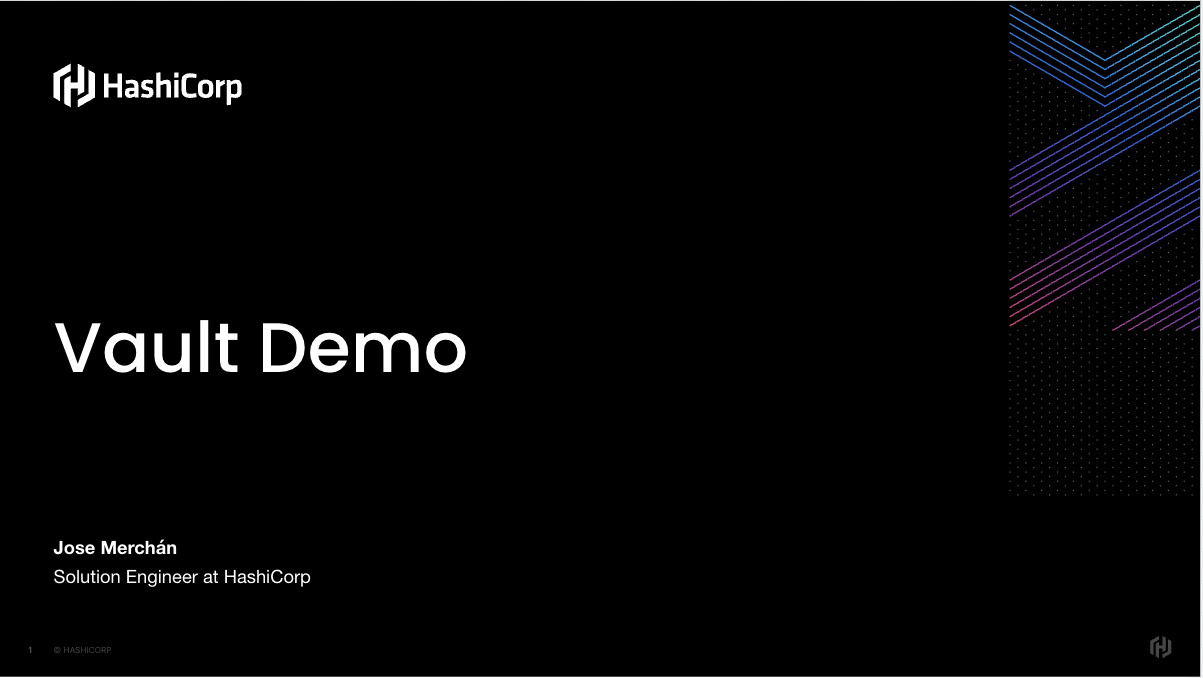


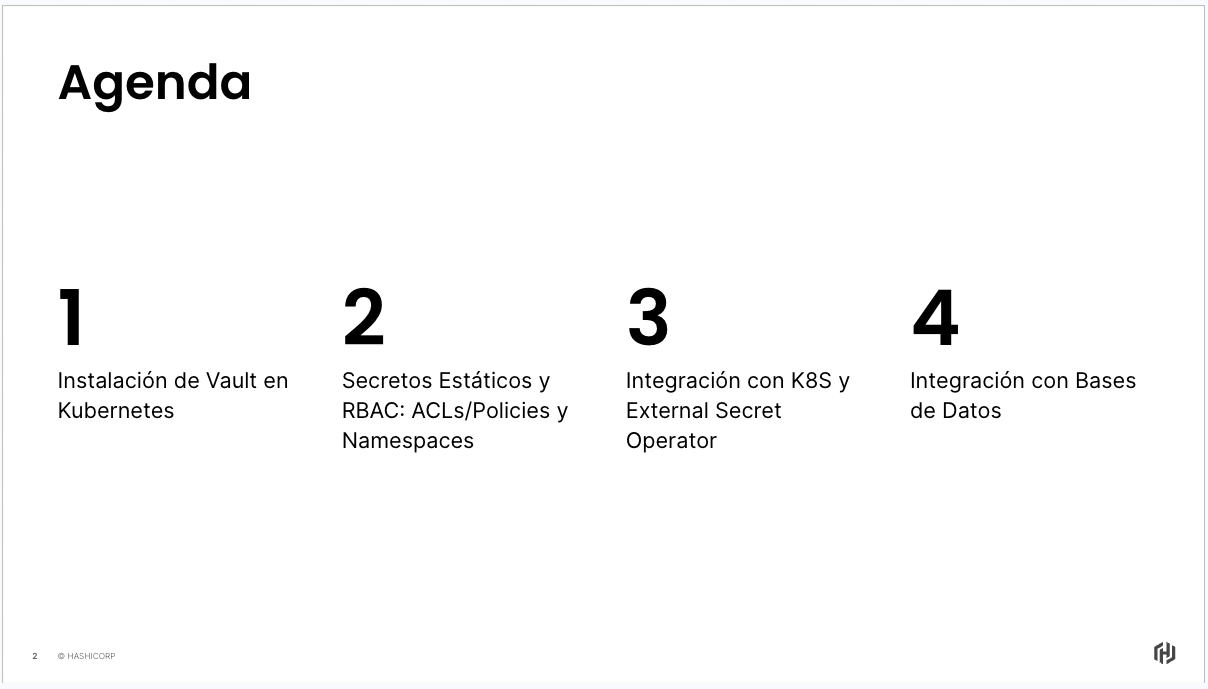

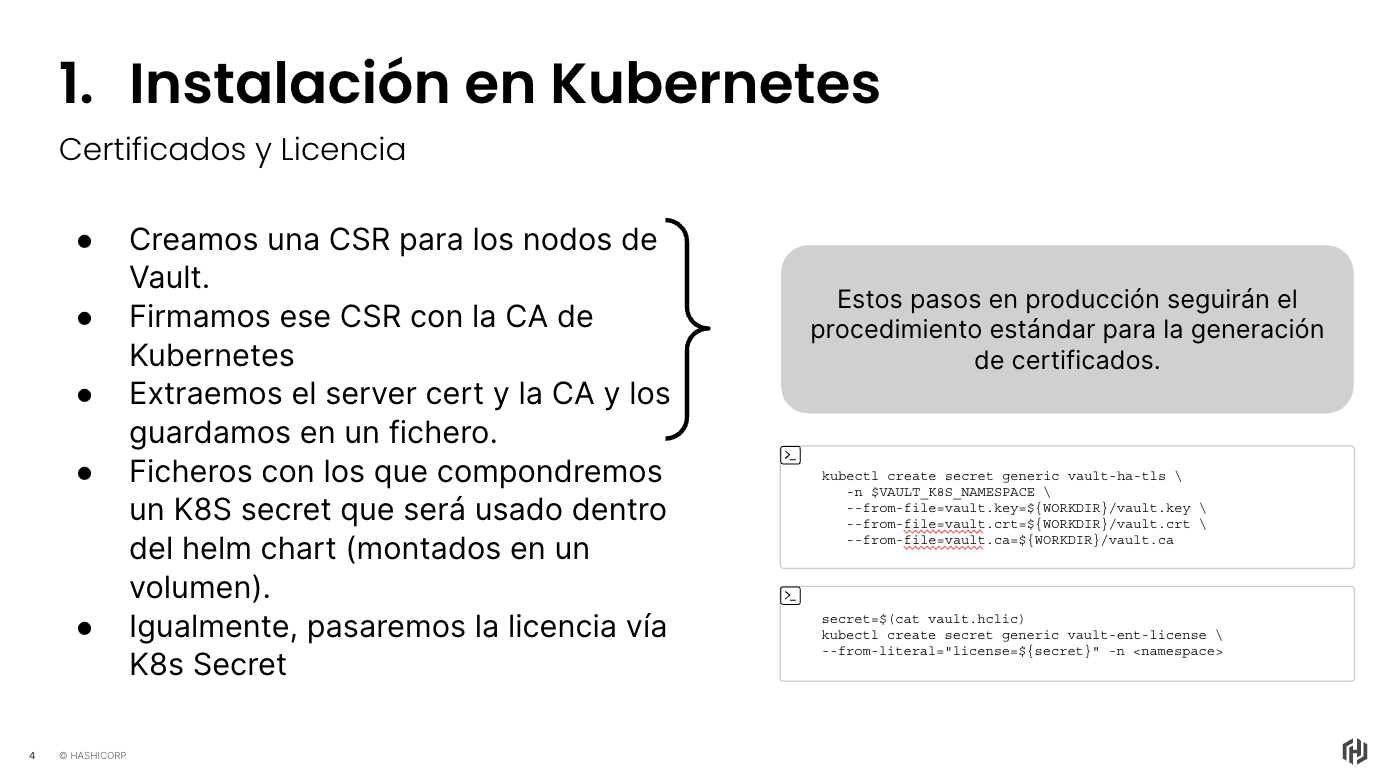

In [ ]:
%%bash
helm repo add hashicorp https://helm.releases.hashicorp.com
helm repo update

In [ ]:
%%bash
rm -rf /tmp/vault
mkdir /tmp/vault

In [ ]:
%%bash
export VAULT_K8S_NAMESPACE="vault" \
export VAULT_HELM_RELEASE_NAME="vault" \
export VAULT_SERVICE_NAME="vault-internal" \
export K8S_CLUSTER_NAME="cluster.local" \
export WORKDIR=/tmp/vault

openssl genrsa -out ${WORKDIR}/vault.key 2048
cat > ${WORKDIR}/vault-csr.conf <<EOF
[req]
default_bits = 2048
prompt = no
encrypt_key = yes
default_md = sha256
distinguished_name = kubelet_serving
req_extensions = v3_req
[ kubelet_serving ]
O = system:nodes
CN = system:node:*.${VAULT_HELM_RELEASE_NAME}.svc.${K8S_CLUSTER_NAME}
[ v3_req ]
basicConstraints = CA:FALSE
keyUsage = nonRepudiation, digitalSignature, keyEncipherment, dataEncipherment
extendedKeyUsage = serverAuth, clientAuth
subjectAltName = @alt_names
[alt_names]
DNS.1 = *.${VAULT_SERVICE_NAME}
DNS.2 = *.${VAULT_SERVICE_NAME}.${VAULT_HELM_RELEASE_NAME}.svc.${K8S_CLUSTER_NAME}
DNS.3 = *.${VAULT_HELM_RELEASE_NAME}
DNS.4 = *.${VAULT_HELM_RELEASE_NAME}.svc.${K8S_CLUSTER_NAME}
IP.1 = 127.0.0.1
EOF

openssl req -new -key ${WORKDIR}/vault.key -out ${WORKDIR}/vault.csr -config ${WORKDIR}/vault-csr.conf


cat > ${WORKDIR}/csr.yaml <<EOF
apiVersion: certificates.k8s.io/v1
kind: CertificateSigningRequest
metadata:
   name: vault.svc
spec:
   signerName: kubernetes.io/kubelet-serving
   # signerName: kubernetes.io/kubelet-serving
   expirationSeconds: 8640000
   request: $(cat ${WORKDIR}/vault.csr|base64|tr -d '\n')
   usages:
   - digital signature
   - key encipherment
   - server auth
EOF

kubectl create -f ${WORKDIR}/csr.yaml
kubectl certificate approve vault.svc
kubectl get csr vault.svc
kubectl get csr vault.svc -o jsonpath='{.status.certificate}' | openssl base64 -d -A -out ${WORKDIR}/vault.crt
kubectl config view \
--raw \
--minify \
--flatten \
-o jsonpath='{.clusters[].cluster.certificate-authority-data}' \
| base64 -d > ${WORKDIR}/vault.ca

kubectl create namespace $VAULT_K8S_NAMESPACE

kubectl create secret generic vault-ha-tls \
   -n $VAULT_K8S_NAMESPACE \
   --from-file=vault.key=${WORKDIR}/vault.key \
   --from-file=vault.crt=${WORKDIR}/vault.crt \
   --from-file=vault.ca=${WORKDIR}/vault.ca


In [ ]:
%env WORKDIR=/tmp/vault
%env VAULT_K8S_NAMESPACE=vault
%env VAULT_HELM_RELEASE_NAME=vault
%env VAULT_SERVICE_NAME=vault-internal 
%env K8S_CLUSTER_NAME=cluster.local 

### Adding enterprise license based on https://developer.hashicorp.com/vault/docs/platform/k8s/helm/enterprise

In [ ]:
%%bash
secret=$(cat /Users/jose/Demo/Vault_ADP/ADP_PlayGround/vault.hclic)
kubectl create secret generic vault-ent-license --from-literal="license=${secret}" -n $VAULT_K8S_NAMESPACE

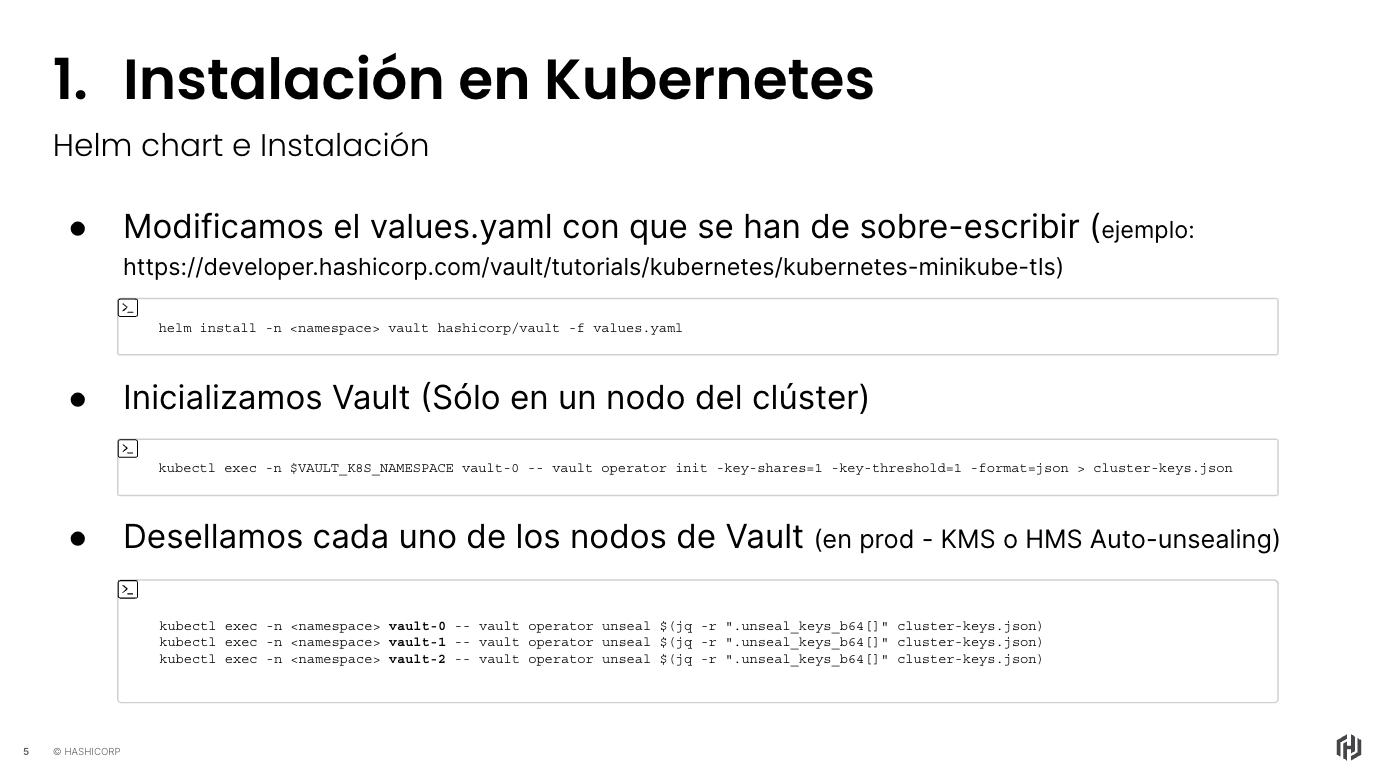

In [ ]:
%%bash
cat > ${WORKDIR}/overrides.yaml <<EOF
global:
   enabled: true
   tlsDisable: false # Disabling TLS to avoid issues when connecting to Vault via port forwarding

injector:
   enabled: false
   #repository: registry.connect.redhat.com/hashicorp/vault-k8s
   # Testing on Mac M1 so moving to arm image
   image:
      repository: docker.io/hashicorp/vault-k8s
      #repository: registry.connect.redhat.com/hashicorp/vault-k8s
      # Testing on Mac M1 so moving to arm image
   agentImage:
      repository: docker.io/hashicorp/vault
      #repository: registry.connect.redhat.com/hashicorp/vault
      # Testing on Mac M1 so moving to arm image

# Supported log levels include: trace, debug, info, warn, error
logLevel: "trace" # Set to trace for initial troubleshooting, info for normal operation

server:
# config.yaml
   image:
      repository: docker.io/hashicorp/vault-enterprise
      tag: 1.15.1-ent

   enterpriseLicense:
      secretName: vault-ent-license
   extraEnvironmentVars:
      VAULT_CACERT: /vault/userconfig/vault-ha-tls/vault.ca
      VAULT_TLSCERT: /vault/userconfig/vault-ha-tls/vault.crt
      VAULT_TLSKEY: /vault/userconfig/vault-ha-tls/vault.key
   volumes:
      - name: userconfig-vault-ha-tls
        secret:
         defaultMode: 420
         secretName: vault-ha-tls
   volumeMounts:
      - mountPath: /vault/userconfig/vault-ha-tls
        name: userconfig-vault-ha-tls
        readOnly: true
   standalone:
      enabled: false
   affinity: "" #No affinity rules so I can install 3 vault instances in a single
   ha:
      enabled: true
      replicas: 3
      raft:
         enabled: true
         setNodeId: true
         config: |
            ui = true
            listener "tcp" {
               tls_disable = 0 # Disabling TLS to avoid issues when connecting to Vault via port forwarding
               address = "[::]:8200"
               cluster_address = "[::]:8201"
               tls_cert_file = "/vault/userconfig/vault-ha-tls/vault.crt"
               tls_key_file  = "/vault/userconfig/vault-ha-tls/vault.key"
               tls_client_ca_file = "/vault/userconfig/vault-ha-tls/vault.ca"
               #api_address = "https://vault-active.vault.svc.cluster.local:8200"
            }
            storage "raft" {
               path = "/vault/data"
            
               retry_join {
                  auto_join             = "provider=k8s namespace=vault label_selector=\"component=server,app.kubernetes.io/name=vault\""
                  auto_join_scheme      = "https"
                  leader_ca_cert_file   = "/vault/userconfig/vault-ha-tls/vault.ca"
                  leader_tls_servername = "vault-0.vault-internal" #Tiene que matchear una SAN del certificado
               }
            
            }
            disable_mlock = true
            service_registration "kubernetes" {}
      # Vault UI
   ui:
      enabled: true
      serviceType: "LoadBalancer"
      serviceNodePort: null
      externalPort: 8200
EOF


In [ ]:
%%bash
helm install -n $VAULT_K8S_NAMESPACE $VAULT_HELM_RELEASE_NAME hashicorp/vault -f ${WORKDIR}/overrides.yaml

In [ ]:
%%bash
kubectl -n $VAULT_K8S_NAMESPACE get pods --watch

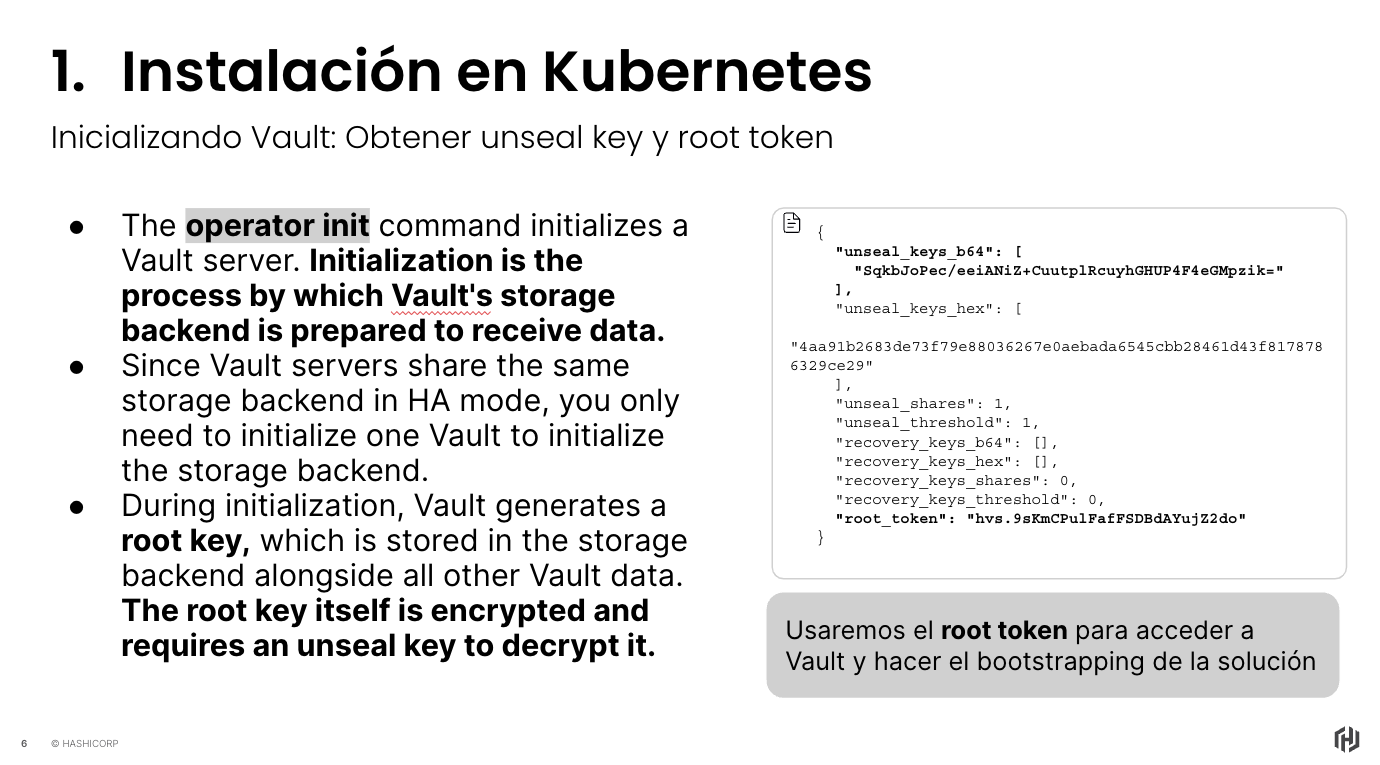

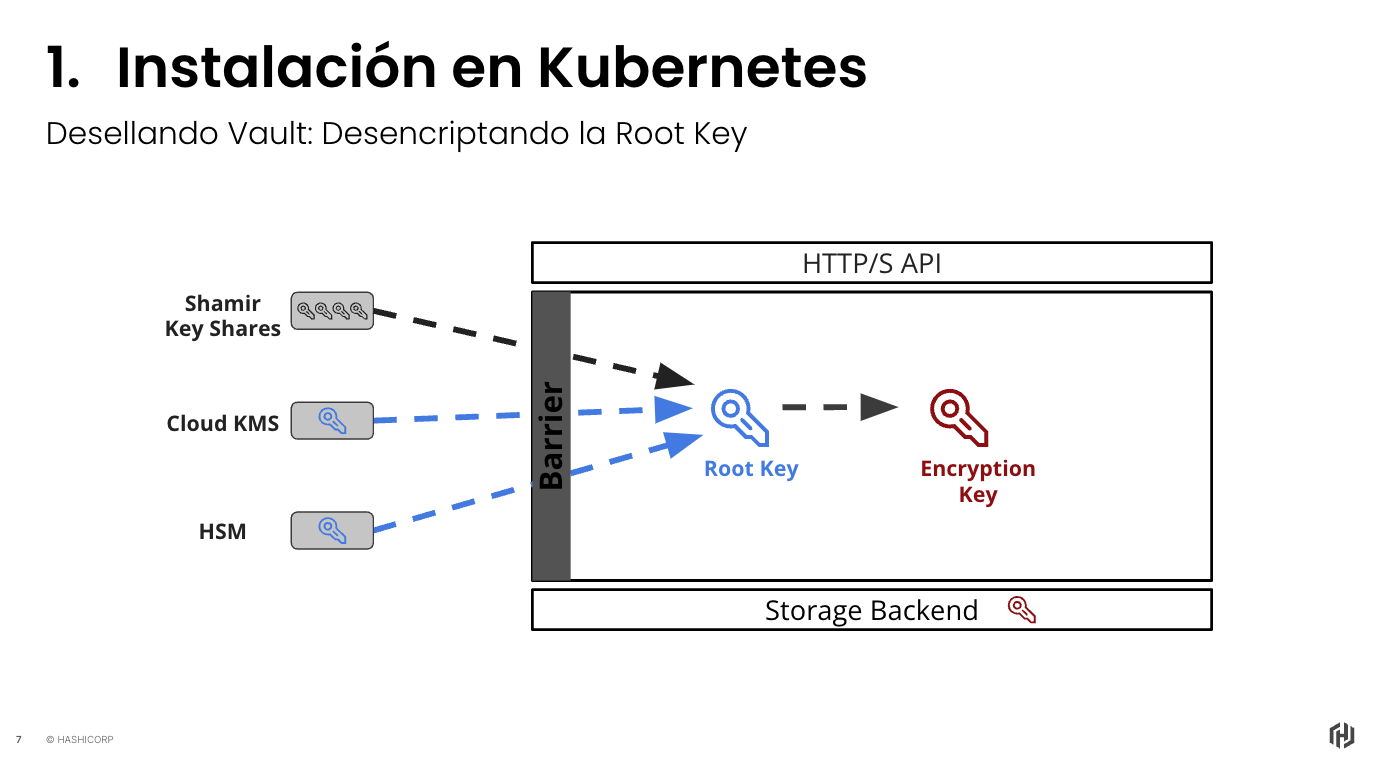

In [ ]:
%%bash
kubectl exec -n $VAULT_K8S_NAMESPACE vault-0 -- vault operator init \
    -key-shares=1 \
    -key-threshold=1 \
    -format=json > ${WORKDIR}/cluster-keys.json

In [ ]:
%%bash
jq -r ".unseal_keys_b64[]" ${WORKDIR}/cluster-keys.json
VAULT_UNSEAL_KEY=$(jq -r ".unseal_keys_b64[]" ${WORKDIR}/cluster-keys.json)

In [ ]:
%%bash
kubectl exec -n $VAULT_K8S_NAMESPACE vault-0 -- vault operator unseal $(jq -r ".unseal_keys_b64[]" ${WORKDIR}/cluster-keys.json)

In [ ]:
%%bash
kubectl exec -n $VAULT_K8S_NAMESPACE vault-1 -- vault operator unseal $(jq -r ".unseal_keys_b64[]" ${WORKDIR}/cluster-keys.json)

In [ ]:
%%bash
kubectl exec -n $VAULT_K8S_NAMESPACE -ti vault-2 -- vault operator unseal $(jq -r ".unseal_keys_b64[]" ${WORKDIR}/cluster-keys.json)

In [ ]:
%%bash
kubectl exec -n $VAULT_K8S_NAMESPACE -ti vault-0 -- vault status

In [ ]:
%%bash
kubectl exec -n $VAULT_K8S_NAMESPACE -ti vault-0 --  vault license inspect

In [ ]:
%%bash
kubectl exec -n $VAULT_K8S_NAMESPACE -ti vault-1 -- vault status

In [ ]:
%%bash
kubectl exec -n $VAULT_K8S_NAMESPACE -ti vault-1 --  vault license inspect

In [ ]:
%%bash
kubectl exec -n $VAULT_K8S_NAMESPACE -ti vault-2 -- vault status

In [ ]:
%%bash
kubectl exec -n $VAULT_K8S_NAMESPACE -ti vault-2 --  vault license inspect

## Get Root Token and port forward to Vault on port 8200

In [ ]:
%%bash
cat ${WORKDIR}/cluster-keys.json | jq -r ".root_token"
cat ${WORKDIR}/cluster-keys.json 

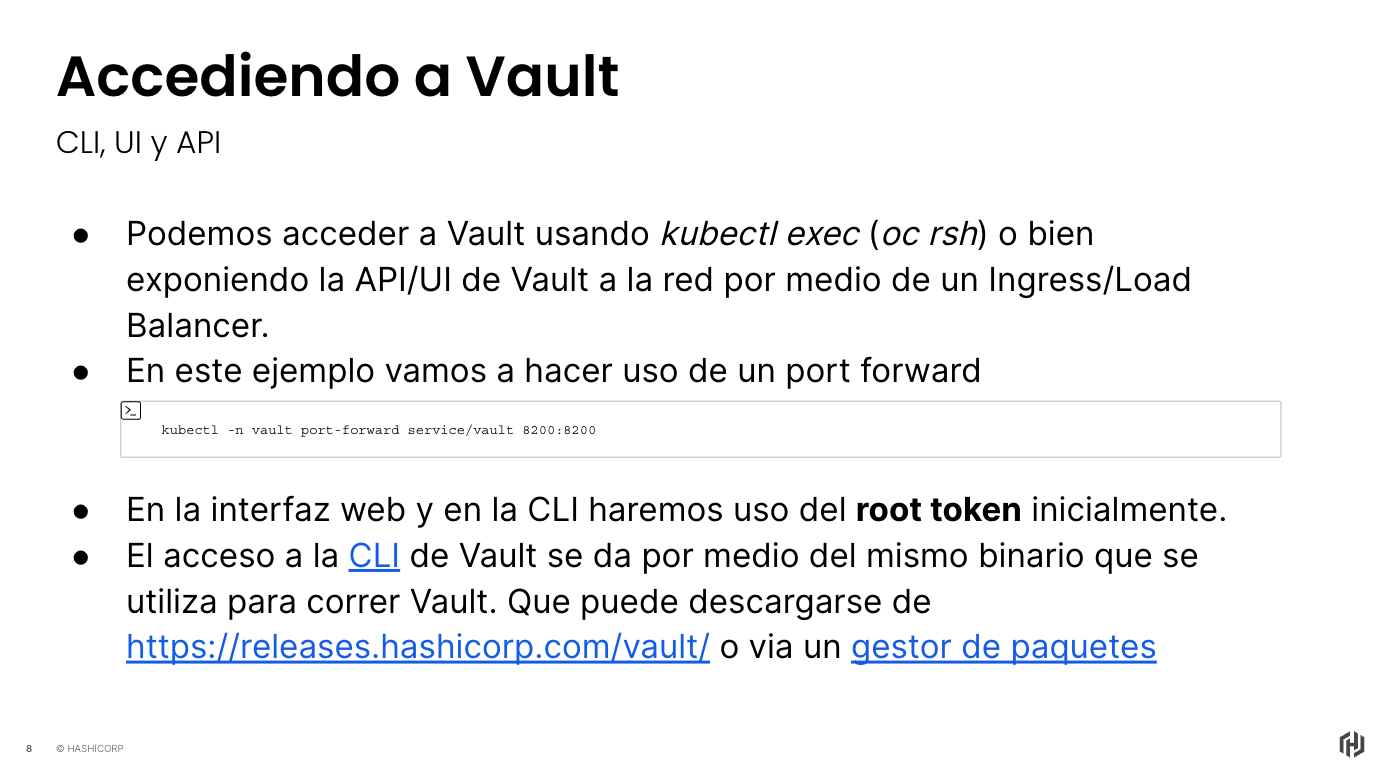

In [20]:
%%bash
#kubectl -n $VAULT_K8S_NAMESPACE get service vault
kubectl -n vault port-forward service/vault 8200:8200 